Hi. Welcome to our Colab. Please put runtime type as GPU. Lets do some pip installs to get started...

In [1]:
# !pip install transformers
# !pip3 install sentencepiece #relevant for speeding-up some tokenizers, specially Pegasus

We start by loading a pre-trained model, and we test it for some basic summarization. First we download the model and the corresponding tokenizer.

In [2]:
# from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModelForSeq2SeqLM

# model_choice="t5" #try too pegasus, prophetnet, bert, bart... or t5... 

#other models and use instructions available here: https://huggingface.co/models?filter=summarization

# if model_choice=="t5":
#   model = AutoModelWithLMHead.from_pretrained("t5-base")
#   tokenizer = AutoTokenizer.from_pretrained("t5-base")
# elif model_choice=="bert":
#   model = AutoModelForSeq2SeqLM.from_pretrained("patrickvonplaten/bert2bert_cnn_daily_mail")
#   tokenizer = AutoTokenizer.from_pretrained("patrickvonplaten/bert2bert_cnn_daily_mail")
# elif model_choice=="pegasus": #This is pretty intense on memory
#   model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-cnn_dailymail")
#   tokenizer = AutoTokenizer.from_pretrained("google/pegasus-cnn_dailymail")
# elif model_choice=="bart": 
#   model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
#   tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
# elif model_choice=="prophetnet":#Does not work, since our version does not seem pre-trained for summarization :()
#   model = AutoModelForSeq2SeqLM.from_pretrained("microsoft/prophetnet-large-uncased")
#   tokenizer = AutoTokenizer.from_pretrained("microsoft/prophetnet-large-uncased")
  
  

  
  


Next we do a basic summarization task, for illustration...

In [1]:
ARTICLE= """Picture this: a herd of elephants flies past you at sixty miles per hour, followed by a streak of tigers, a pride of lions, and a bunch of clowns. 
What do you see? It must be a circus train! One of the first uses of the circus train is credited to W.C. Coup. He 
partnered with P.T. Barnum in 1871 to expand the reach of their newly combined shows using 
locomotives. Before circus trains, these operators had to lug around all of their animals, 
performers, and equipment with a team of more than 600 horses. Since there were no highways, 
these voyages were rough and took a long time. Circuses would stop at many small towns 
between the large venues. Performing at many of these small towns was not very profitable. 
Because of these limitations, circuses could not grow as large as the imaginations of the 
operators. After they began using circus trains, Barnum and Coup only brought their show to 
large cities. These performances were much more profitable and the profits went toward creating 
an even bigger and better circus. Multiple rings were added and the show went on. Today, 
Ringling Bros. and Barnum and Bailey Circus still rely on the circus train to transport their 
astounding show, but now they use two."""


In [2]:
# inputs = tokenizer.encode("summarize: " + ARTICLE, return_tensors="pt", truncation=True, max_length=512)
# outputs = model.generate(inputs, max_length=150, min_length=40, num_beams=4, length_penalty=2.0, early_stopping=True)
# print("Your summary: ")
# print(tokenizer.decode(outputs[0]))

Nice! :) Now we aim to fine-tune a model to do the same task. Let's start testing the way of doing it from here: https://github.com/ohmeow/ohmeow_website/blob/master/_notebooks/2020-05-23-text-generation-with-blurr.ipynb

In [3]:
# only run this cell if you are in collab
# !pip install --user ohmeow-blurr -q
# !pip install --user datasets -q

In [4]:
# !pip show ohmeow-blurr

In [1]:
import datasets
import pandas as pd
from fastai.text.all import *
from transformers import *
from torch.utils.tensorboard import SummaryWriter

from blurr.data.all import *
from blurr.modeling.all import *

In [2]:
# %load_ext autoreload
# %autoreload 2
# from fastai.vision import *
# import fastai.callback.all
# from fastai.callbacks import *


# from TensorBoardCallback import *

In [3]:
DATASET = 'reddit_tifu'
VERSION = 'long'
EPOCHS = 20
BATCH_SIZE = 2
model_choice="blenderbot"
if DATASET == 'wikihow':
    data_dir = r"D:\Workspace\OVGU\Chatbot\Dataset"

In [4]:
raw_data = datasets.load_dataset(DATASET,VERSION, split='train[:20]')#should be 100% instead of 300
test_data = datasets.load_dataset(DATASET,VERSION, split='train[2000:2200]')#should be 100% instead of 300

Reusing dataset reddit_tifu (C:\Users\49176\.cache\huggingface\datasets\reddit_tifu\long\1.1.0\c383d53c57bebbb2972419fc23c3f58639c7f9074004ef1c49c1c0bcfa2218a3)
Reusing dataset reddit_tifu (C:\Users\49176\.cache\huggingface\datasets\reddit_tifu\long\1.1.0\c383d53c57bebbb2972419fc23c3f58639c7f9074004ef1c49c1c0bcfa2218a3)


In [5]:
df = pd.DataFrame(raw_data)
df_test = pd.DataFrame(test_data)

pre trained model and model class for summarization (ConditionalGeneration)

In [6]:
df.head(3)

,documents,num_comments,score,title,tldr,ups,upvote_ratio
0,"this actually happened a couple of years ago. i grew up in germany where i went to a german secondary school that went from 5th to 13th grade (we still had 13 grades then, they have since changed that). my school was named after anne frank and we had a club that i was very active in from 9th grade on, which was dedicated to teaching incoming 5th graders about anne franks life, discrimination, anti-semitism, hitler, the third reich and that whole spiel. basically a day where the students' classes are cancelled and instead we give them an interactive history and social studies class with lot...",23.0,115.0,gender-stereotyping,confuse a 5th grade girl for a boy in front of half of her class. kids are mean. sorry sandra.**,115.0,0.88
1,"it was last october, but i'm feeling the fall-out from it the most today. \n\nafter my mom died from cancer last year, i started looking for my estranged father. i had only known him for a short time when i was 6 and barely remembered more than his name. i never knew why he left and my mom would not talk about him without obvious emotional pain, so i didn't push her for information about him. i figured he didn't care about us.\n\ni had googled him multiple times over the years, but he was always unlisted and i didn't have an address with which to search. after her death, i felt strong...",12.0,16.0,telling my dad that i love him.,"i found my estranged dad, thought i loved him after getting to know him, got to know him better and changed my mind.",16.0,0.79
2,"so i had the brilliant idea to use veet hair removal gel as the ol' danglies were in need of a trim and i had heard that veet leaves them smoother for longer. well i guess thats right when the skin has to grow back first. \n\npre-story: i tried this before and the results were great but i had decided to do it again because of how well it worked. \n\nso i take out the gel/cream stuff and just lob it on and cover the forest. the slight peroxide kinda smell ensued and all was going well, there was a slight burning but thats to be expected, you know, melting pubes off does that. so comes the a...",10.0,55.0,i was deveeted...,had my balls burned by sauron and was left deveeted.,55.0,0.85


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   documents     2000 non-null   object 
 1   num_comments  2000 non-null   float64
 2   score         2000 non-null   float64
 3   title         2000 non-null   object 
 4   tldr          2000 non-null   object 
 5   ups           2000 non-null   float64
 6   upvote_ratio  2000 non-null   float64
dtypes: float64(4), object(3)
memory usage: 109.5+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   documents     200 non-null    object 
 1   num_comments  200 non-null    float64
 2   score         200 non-null    float64
 3   title         200 non-null    object 
 4   tldr          200 non-null    object 
 5   ups           200 non-null    float64
 6   upvote_ratio  200 non-null    float64
dtypes: float64(4), object(3)
memory usage: 11.1+ KB


In [9]:
df.isnull().sum()

documents       0
num_comments    0
score           0
title           0
tldr            0
ups             0
upvote_ratio    0
dtype: int64

In [10]:
df.dtypes

documents        object
num_comments    float64
score           float64
title            object
tldr             object
ups             float64
upvote_ratio    float64
dtype: object

In [6]:
df = df.loc[:,['documents','tldr']]
df_test = df_test.loc[:,['documents','tldr']]

In [7]:
df.columns,df_test.columns

(Index(['documents', 'tldr'], dtype='object'),
 Index(['documents', 'tldr'], dtype='object'))

In [13]:
df.iloc[0,0]

'this actually happened a couple of years ago. i grew up in germany where i went to a german secondary school that went from 5th to 13th grade (we still had 13 grades then, they have since changed that). my school was named after anne frank and we had a club that i was very active in from 9th grade on, which was dedicated to teaching incoming 5th graders about anne franks life, discrimination, anti-semitism, hitler, the third reich and that whole spiel. basically a day where the students\' classes are cancelled and instead we give them an interactive history and social studies class with lots of activities and games. \n\nthis was my last year at school and i already had a lot of experience doing these project days with the kids. i was running the thing with a friend, so it was just the two of us and 30-something 5th graders. we start off with a brief introduction and brainstorming: what do they know about anne frank and the third reich? you\'d be surprised how much they know. anyway af

In [11]:
pd.set_option('display.max_columns', 500)  

In [12]:
df.head(1)

,documents,tldr
0,"this actually happened a couple of years ago. i grew up in germany where i went to a german secondary school that went from 5th to 13th grade (we still had 13 grades then, they have since changed that). my school was named after anne frank and we had a club that i was very active in from 9th grade on, which was dedicated to teaching incoming 5th graders about anne franks life, discrimination, anti-semitism, hitler, the third reich and that whole spiel. basically a day where the students' classes are cancelled and instead we give them an interactive history and social studies class with lot...",confuse a 5th grade girl for a boy in front of half of her class. kids are mean. sorry sandra.**


In [15]:
model_choice="blenderbot"
#We try to only use base models for training. We haven't got so many resources or time ;)

"""
Working models: 
- Bert works.. it comes already trained for summarization and we add on that...
- Bart works.. (but this might not be RXF), similarly, it seems to be already trained for summarization, so we might just add on that
- t5 apparently working, but it seems to be already trained for summarization, so we might just add on that
- pegasus working, but it seems it is precisely trained for summarization, so we might just add on that
- blenderbot seems to be working and results in something like a summarizer with a strong personality, with a lot of extractive behavior
- prophetnet seems to be working after some adaptation... overall good results
"""
if DATASET == 'cnn':
    

    if model_choice=="t5":
      pretrained_model_name = "t5-base"
      m_cls= T5ForConditionalGeneration
    elif model_choice=="bert":
      pretrained_model_name = "patrickvonplaten/bert2bert_cnn_daily_mail"#"this is the only model we have that really is structured as an encoder_decoder in HF
      m_cls=EncoderDecoderModel
    elif model_choice=="pegasus":  
      pretrained_model_name = "google/pegasus-large" #large pegasus really uses a lot of RAM :(
      m_cls=PegasusForConditionalGeneration
    elif model_choice=="bart": 
      pretrained_model_name = "facebook/bart-base"
      m_cls=BartForConditionalGeneration
    elif model_choice=="prophetnet":
      pretrained_model_name = "microsoft/prophetnet-large-uncased-cnndm"
      m_cls=ProphetNetForConditionalGeneration
    elif model_choice=="blenderbot":
      pretrained_model_name = "facebook/blenderbot-90M"
      m_cls=BlenderbotForConditionalGeneration
else:
    if model_choice=="t5":
      pretrained_model_name = "deep-learning-analytics/wikihow-t5-small"
      m_cls= T5ForConditionalGeneration
#     elif model_choice=="bert":
#       pretrained_model_name = "patrickvonplaten/bert2bert_cnn_daily_mail"#"this is the only model we have that really is structured as an encoder_decoder in HF
#       m_cls=EncoderDecoderModel
    elif model_choice=="pegasus":  
      pretrained_model_name = "google/pegasus-wikihow" #large pegasus really uses a lot of RAM :(
      m_cls=PegasusForConditionalGeneration
    elif model_choice=="bart": 
      pretrained_model_name = "facebook/bart-base"
      m_cls=BartForConditionalGeneration
    elif model_choice=="prophetnet":
      pretrained_model_name = "microsoft/prophetnet-large-uncased-cnndm"
      m_cls=ProphetNetForConditionalGeneration
    elif model_choice=="blenderbot":
      pretrained_model_name = "facebook/blenderbot-90M"
      m_cls=BlenderbotForConditionalGeneration
    
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, model_cls=m_cls)
print(hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model))
if model_choice=="blenderbot":#we benefit from the similar code structure in Hugging Face
  hf_arch="bart"
if model_choice=="bert":
  hf_arch="bert_encoder_decoder"
print(hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model))

blenderbot <class 'transformers.models.blenderbot.configuration_blenderbot.BlenderbotConfig'> <class 'transformers.models.blenderbot.tokenization_blenderbot.BlenderbotSmallTokenizer'> <class 'transformers.models.blenderbot.modeling_blenderbot.BlenderbotForConditionalGeneration'>
bart <class 'transformers.models.blenderbot.configuration_blenderbot.BlenderbotConfig'> <class 'transformers.models.blenderbot.tokenization_blenderbot.BlenderbotSmallTokenizer'> <class 'transformers.models.blenderbot.modeling_blenderbot.BlenderbotForConditionalGeneration'>


Build data blocks

In [16]:
hf_batch_tfm = HF_SummarizationBeforeBatchTransform(hf_arch, hf_tokenizer, max_length=[256, 130])

blocks = (HF_TextBlock(before_batch_tfms=hf_batch_tfm, input_return_type=HF_SummarizationInput), noop)

if DATASET == 'cnn':
    dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('article'), 
                   get_y=ColReader('highlights'), 
                   splitter=RandomSplitter())
else:
    dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('documents'), 
                   get_y=ColReader('tldr'), 
                   splitter=RandomSplitter())


In [17]:
dls = dblock.dataloaders(df, bs=BATCH_SIZE, num_workers=0)

In [18]:
len(dls.train.items), len(dls.valid.items)

(1600, 400)

In [19]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 35]))

In [20]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"like any great tifu, this did not happen today. instead, this story took place about a year and a half ago while at a conference in nashville, tennessee. nbsp; __newln__ before i begin, you should know i'm an extrovert. in many instances, it's great. for this story in particular, it's a pain in the ass. __newln__ nbsp; __newln__ in early july, an almost 20 year old version of me was sent to represent an organization at a conference in nashville. i was sent with another colleague of mine, who for this story, we will call brian. in addition to brain, another friend of mine we'll call him john"" ), was on the national board and also attended the conference. it's important to note that both brian and john were 21. __newln__ nbsp; __newln__ so here i am, 19 years old, in one of the coolest cities i have had the pleasure of visiting. obviously, being there for my organization meant that we would be busy during the day, however, the night was ours to grab by the balls. __newln__ nbsp; __newln__ after the first day of business, brian, john and i met up",went to a strip club by myself for the first time and paid 200 only to sing to and be serenaded by a stripper. i'm never going back.
1,"this wasn't today. at the urging of several redditorseveral months, i present one of my greatest kups. a long time ago, in a galaxy far, far away, i was hired to get the code for a company under control. they made gps tracking collars for animals. everything had grown organically, and so as an engineer they figure that i could get an organized codebase installed. i'd been programming since i was eight years old, and with fresh training they figured i would be ideal for getting organized, clean code. i didn't know how to program in c, but i learned. i got a book and read up on the ideas and constraints. i learned about registers and bitwise manipulation and all the rest. eventually i even got to the point where i was able to work out a bug between the chip manufacturer and the chip burner manufacturer to get the registers moved. that solved a global bug, so if you ever used a 10f20x with a quickwriter and it worked, you're welcome. __newln__ i also made the code modular, so when parts changes i could just use a different include and it would work just fine. this was instrumental when the memory war ended.",government of india shot a tiger because i made a typo.


In [21]:
if model_choice=="pegasus" or model_choice=="blenderbot" or model_choice=="bert":
  text_gen_kwargs = { **{'max_length': 130, 'min_length': 20} }
else:
  text_gen_kwargs = { **hf_config.task_specific_params['summarization'], **{'max_length': 130, 'min_length': 30} }
if model_choice=="t5" and "prefix" in text_gen_kwargs :
  del text_gen_kwargs["prefix"]

text_gen_kwargs

{'max_length': 130, 'min_length': 20}

In [22]:
text_gen_kwargs = { **{
 'diversity_penalty': 0.0,
 'max_length': 130,
 'min_length': 20,
 'num_beam_groups': 1,
 'num_beams': 10,
 'temperature': 1.0}}



In [23]:
text_gen_kwargs

{'diversity_penalty': 0.0,
 'max_length': 130,
 'min_length': 20,
 'num_beam_groups': 1,
 'num_beams': 10,
 'temperature': 1.0}

In [24]:
# writer = SummaryWriter('runs/text_summarization_blenderbot_reddit')


In [26]:
import torch
model = HF_BaseModelWrapper(hf_model)
model_cb = HF_SummarizationModelCallback(text_gen_kwargs=text_gen_kwargs)

def sum_split(m, arch):#Small change to the blurr overall flow, so it works with bert and prophetnet
    """Custom param splitter for summarization models"""
    model = m.hf_model if (hasattr(m, 'hf_model')) else m

    if arch in ['bert_encoder_decoder']:#this still might need improvements
        embeds = nn.Sequential(
          model.encoder.embeddings.word_embeddings,
          model.encoder,
          model.decoder.cls.predictions.decoder
        )
        groups = L(embeds, model.encoder, model.decoder.cls.predictions.decoder)
        return groups.map(params).filter(lambda el: len(el) > 0)
    if arch in ['prophetnet']:
        embeds = nn.Sequential(
          model.prophetnet.word_embeddings,
          model.prophetnet.encoder,
          model.prophetnet.decoder,
        )
        groups = L(embeds, model.prophetnet.encoder, model.prophetnet.decoder)
        return groups.map(params).filter(lambda el: len(el) > 0)
    raise ValueError('Invalid architecture')

if model_choice!="bert" and model_choice!="prophetnet":
  learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=[model_cb],
                splitter=partial(summarization_splitter, arch=hf_arch)).to_fp16()
else:
  learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=[model_cb],
                splitter=partial(sum_split, arch=hf_arch))#.to_fp16()

learn.create_opt() 
learn.freeze()

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=2.290867567062378)

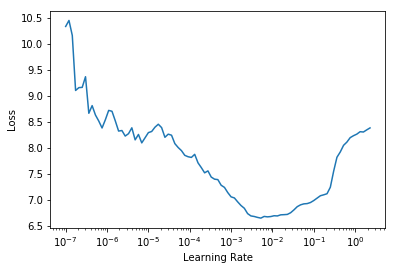

In [27]:
learn.lr_find(suggestions=True)

In [27]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(3,
 tensor(8.8450, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([5, 80, 54944]))

In [29]:
learn.fit_one_cycle(EPOCHS, lr_max=1e-3) 

#Takes about 5 minutes for a super small split (time depends on the model and data split), as a recommendation try something like split='train[:300] for first tests.... Good thing is that you see a progress bar ;)
#Note it would be nice to log the statistics per cycle...

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time


KeyboardInterrupt: 

In [35]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    np.savetxt("test.csv", metrics, delimiter=",")
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [36]:
learn.recorder.metric_names


(#7) ['epoch','train_loss','valid_loss','rouge1','rouge2','rougeL','time']

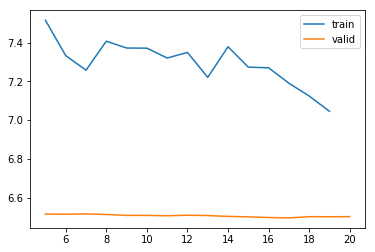

In [37]:
learn.recorder.plot_loss()


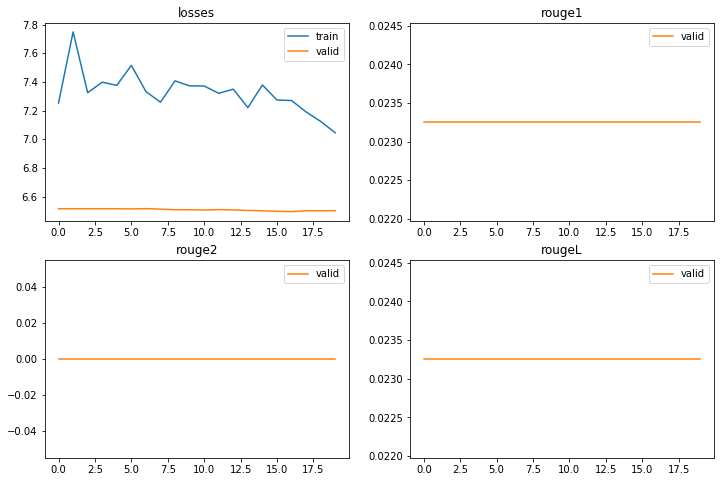

In [38]:
# filename = model_choice+'_'+"try_1.csv"

learn.recorder.plot_metrics()


In [40]:
# learn.csv_logger.read_logged_file()

In [41]:
learn.path.ls()

(#12) [Path('.ipynb_checkpoints'),Path('blenderbot_ep20_batch5_ft_reddit_tifu_long_export.pkl'),Path('blenderbot_ep3_batch2_ft_wikihow_sep_export.pkl'),Path('blenderbot_ep3_ft_cnndm_export.pkl'),Path('history.csv'),Path('models'),Path('results_100.pkl'),Path('runs'),Path('t5_ep3_batch2_ft_wikihow_sep_export.pkl'),Path('Text_Summarization_Chatbot Blender reddit-TEST.ipynb')...]

In [48]:
learn.recorder.log

(#7) [1,6.7862629890441895,5.980216026306152,0.06666666666666667,0.0,0.03333333333333333,'00:02']

In [39]:
history

In [30]:
learn.show_results(learner=learn, max_n=2)

,text,target,prediction
0,"hello reddit, __newln__ i'm not sure if this would count as a tifu post.. but i figured you would like it. __newln__ this happened when i was 18 years old.. naive.. and stupid. ok, so here it goes! __newln__ i met a girl once at a show. she seemed cool, dtf, and it was mutual. we traded numbers and hung out a few days later. our hanging out consisted of late night meet ups, long talks, and aggressively making out. we both lived at home with our parents.. so sex was hard to arrange at times. about two weeks go by and we end up going over to her house at 1am. we started making out and one thing led to another and we have our pants off about to do the thing. this is when i fucked up.. this single moment would change my life. i have always wore condoms.. i wasam all about that shit. if thing were getting heated and i didn't have a condom.. i would just say no.. or we would do something else. not this time. the build up of making out every night and getting blue balls was wayyyy to much. so, we had sex",slept with a girl and didn't wear a condom. she said she was pregnant. then she said she wasn't. i asked to be friends.. she said she was pregnant again and it was just cramps.. she fakes abortion. i ask to be friends.. she says she has cancer and 8 months to live.. i go through hell for a long time.. she cheats on me with a friend.. i break up with her and move into my own place.. she stalks me for a little bit and still tries to contact me through email.,"to make out with my girlfriend , got blue balls . . . not the best way to be described . . * * * * blue balls * * "" are not the same as red balls , but i get what you ' re saying . . : )"
1,"obligatory this happened over the course of a year and a half"", throwaway, and sorry for formatting; am on mobile, yadda yadda. __newln__ i suppose you could say my fu started during the winter of my senior year, back in 2013. i was on a trip with my high school drama club, where i met this guy for the sake of the story i'll call him c ). he seemed pretty nice, smart, funny, and it didn't hurt that he wasn't too bad looking. we met through a mutual friend and began talking. at the time, i didn't realize i was making a huge mistake. naturally, i caught feelings and he felt the same way. we briefly talked about dating but other than that we stayed friends. it wasn't until i had a spurofthemoment decision to throw a new year's party that the possibility of us dating seemed to become more and more likely. long story short, he kissed me as the ball dropped and we made out the rest of the night. this wouldn't necessarily be worrying, except that's not how i do. my friends who witnessed this said that that behavior was extremely uncharacteristic","an asshole despite warning signs, got emotionally fucked up, and did research that further fucked me up. also, i know what the rules say about posting about assault but because i didn't commit the assault, i'm assuming i'm in the clear.",friend kissed me as the ball dropped and i made out the rest of the night . i don ' t know what to do now . . .


In [31]:
test_article = """
The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,050 even before the Air Asia plane vanished. Two incidents involving Malaysia Airlines planes - one over eastern Ukraine and the other in the Indian Ocean - led to the deaths of 537 people, while an Air Algerie crash in Mali killed 116 and TransAsia Airways crash in Taiwan killed a further 49 people. The remaining 456 fatalities were largely in incidents involving small commercial planes or private aircraft operating on behalf of companies, governments or organisations. Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 - totalling just 111 across the whole world over the past 12 months. The all-time deadliest year for aviation was 1972 when a staggering 2,429 people were killed in a total of 55 plane crashes - including the crash of Aeroflot Flight 217, which killed 174 people in Russia, and Convair 990 Coronado, which claimed 155 lives in Spain. However this year's total death count of 1,212, including those presumed dead on board the missing Air Asia flight, marks a significant rise on the very low 265 fatalities in 2013 - which led to it being named the safest year in aviation since the end of the Second World War. Scroll down for videos. Deadly: The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,158 even before the Air Asia plane (pictured) vanished. Fatal: Two incidents involving Malaysia Airlines planes - one over eastern Ukraine (pictured) and the other in the Indian Ocean - led to the deaths of 537 people. Surprising: Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949. 2014 has been a horrific year for Malaysia-based airlines, with 537 people dying on Malaysia Airlines planes, and a further 162 people missing and feared dead in this week's Air Asia incident. In total more than half the people killed in aviation incidents this year had been flying on board Malaysia-registered planes. In January a total of 12 people lost their lives in five separate incidents, while the same number of crashes in February killed 107. 
"""

In [32]:
outputs = learn.blurr_summarize(test_article, early_stopping=True, num_beams=4, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
' s been a terrible year for malaysiabased airlines , with the total number of fatalities so far this decade being the lowest since the first commercial jet airliner took off in 1949 . in january a total of 12 people lost their lives in a plane crash , and the same number of deaths in the plane crash .

=== Prediction 2 ===
' s been a terrible year for malaysiabased airlines , with the total number of fatalities so far this decade being the lowest since the first commercial jet airliner took off in 1949 . in january a total of 12 people lost their lives in a plane crash , and the same number of deaths in the plane crash . in 2013 , the number of people killed by malaysian airlines went from 1 050 to 1 00 in a week . in 2014 , more than half of the people died in plane crashes . in 2017 , the numbers went from 2 00 to 2 000 . in 2016 , a lot of people died

=== Prediction 3 ===
' s been a terrible year for malaysiabased airlines , with the total number of fatalities

In [34]:
learn.export(fname=model_choice+'_ep'+str(EPOCHS)+'_batch'+str(BATCH_SIZE)+'_ft_'+DATASET+'_'+VERSION+'_export.pkl')

In [39]:
inf_learn = load_learner(fname=model_choice+'_ep'+str(EPOCHS)+'_batch'+str(BATCH_SIZE)+'_ft_'+DATASET+'_'+VERSION+'_export.pkl')
inf_learn.blurr_summarize(test_article)#For the bert encoder decoder combo this takes surprisingly quite a lot of time!

["it ' s crazy to think that fatality has been the worst since the first commercial jet airliner took off in 1949 . fatal: two incidents involving malaysia airlines planes - one over eastern ukraine pictured , which killed 174 people in russia , and convair 990 coronado , which claimed sawlives in spain . however this year ' s total death count of 1 212 , including those presumed dead on board the missing air asia flight , marks a significant rise on the very low 265 fatalities in aviation since the second world war . scroll down for videos . deadly: the past 12 months are the worst for"]

In [35]:
learn.blurr_summarize(ARTICLE)#We check now with the original article from the beginning
#For the bert encoder decoder combo this takes more time than for others

['circus trains stopped at small towns between large cities . multiple rings were added and the show went on . today , barnum and bailey circus still rely on the train to transport their shows , but now they use two . what do you think happened ?']